<div align="center">
    <h1>Aprendizaje automático</h1>
    <h3>Fundamentos y aplicaciones en meteorología del espacio</h3>
    <h4>TP 2: Predicción</h4>
    <h5>Alumno: Federico Iza</h5>
</div>

In [27]:
import pandas as pd
from tp2_settings import *
import matplotlib.pyplot as plt
from utils.plot import config_plots
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
import tensorflow as tf

In [ ]:
%matplotlib inline
config_plots()

## Data Acquisition

In [ ]:
# Read data with selected columns
df = pd.read_csv('../data/sym_h_reduced.csv',
                 usecols=['timestamp', 'SYM-H'])

# Rename columns
df.rename(columns={'timestamp': 'Timestamp'}, inplace=True)

# Transform string to datetime format
date_format = '%Y-%m-%d %H:%M:%S'
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format=date_format)

In [ ]:
df.head()

,Timestamp,SYM-H
0,2013-02-01 00:00:00,-10.0
1,2013-02-01 00:01:00,-10.0
2,2013-02-01 00:02:00,-10.0
3,2013-02-01 00:03:00,-10.0
4,2013-02-01 00:04:00,-10.0


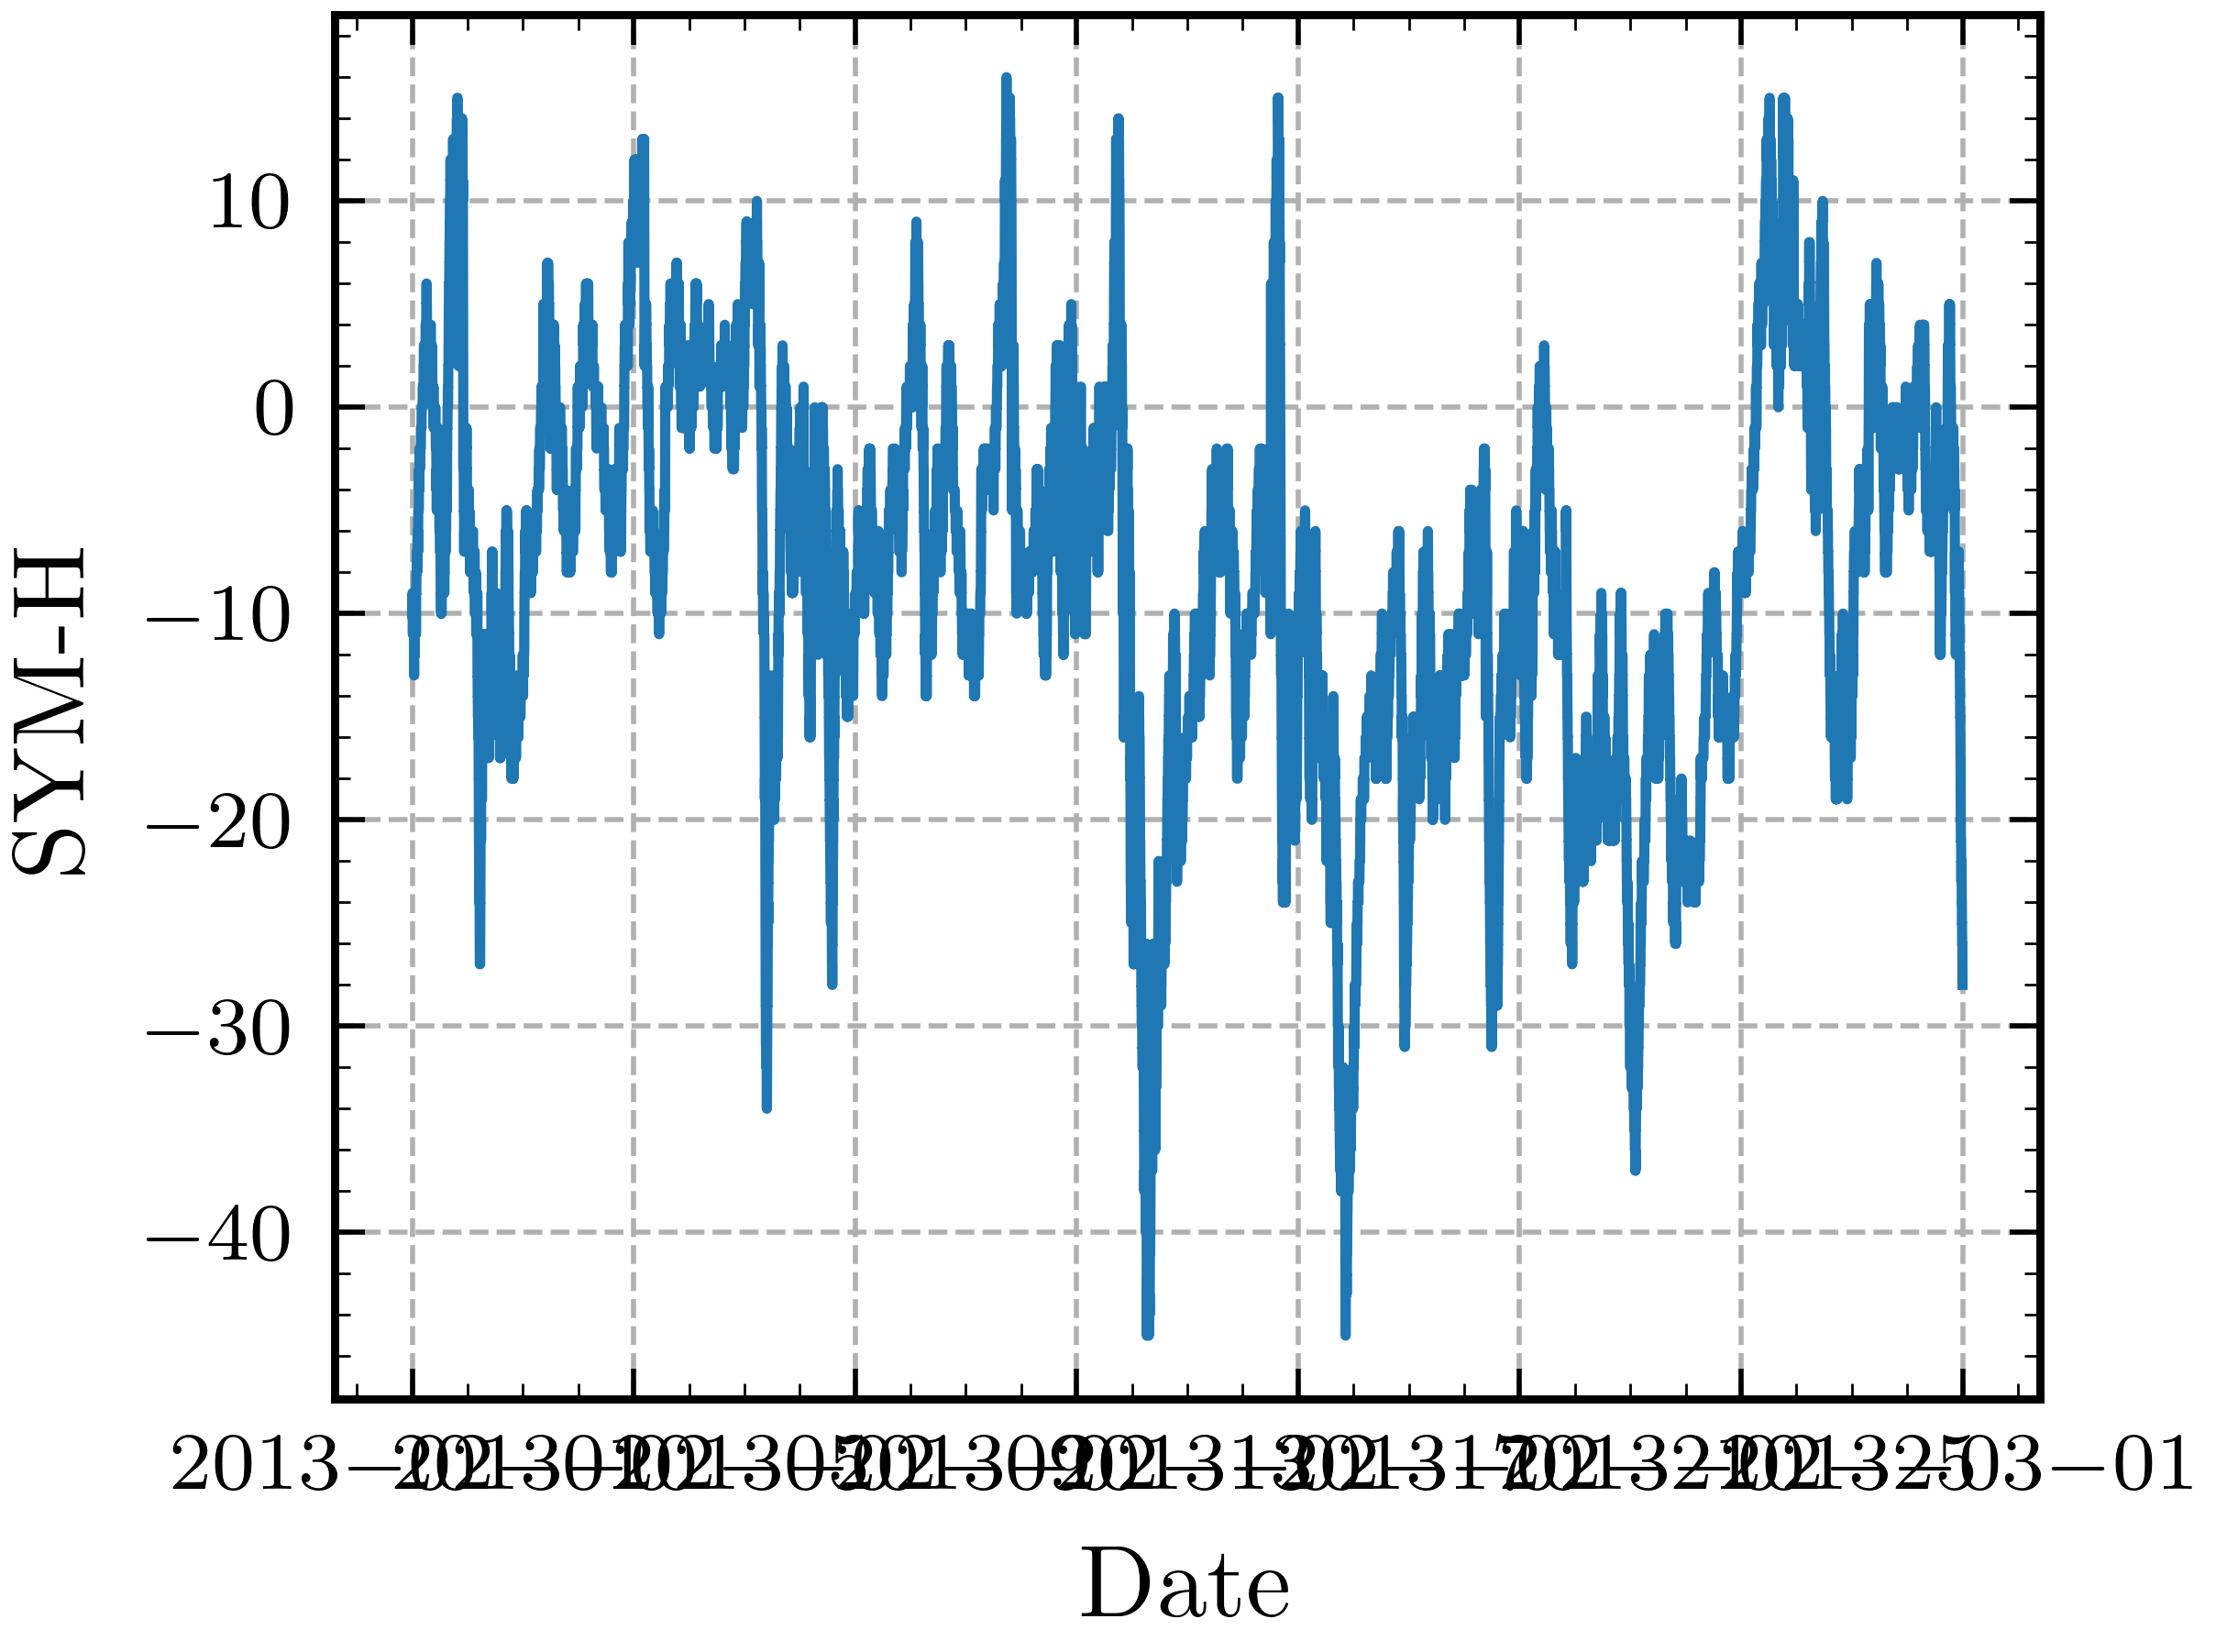

In [ ]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel('Date')
ax.set_ylabel('SYM-H')
# ax.set_xlim(0, N_EPOCHS['radar'])
# ax.set_ylim(0, 5)

ax.plot(df['Timestamp'], df['SYM-H'], color='tab:blue',
        ls='-', lw=1)

# ax.legend(loc='upper right', framealpha=0)
# fig.savefig('../images/tp2_fig1.pdf')
plt.show()

In [ ]:
init_day = '01'
init_month = '02'
init_year = '2013'
init_date = f'{init_year}-{init_month}-{init_day}'

end_day = '10'
end_month = '02'
end_year = '2013'
end_date = f'{end_year}-{end_month}-{end_day}'

In [ ]:
df_reduced = df.loc[(df['Timestamp'] >= init_date)
                    & (df['Timestamp'] <= end_date)]

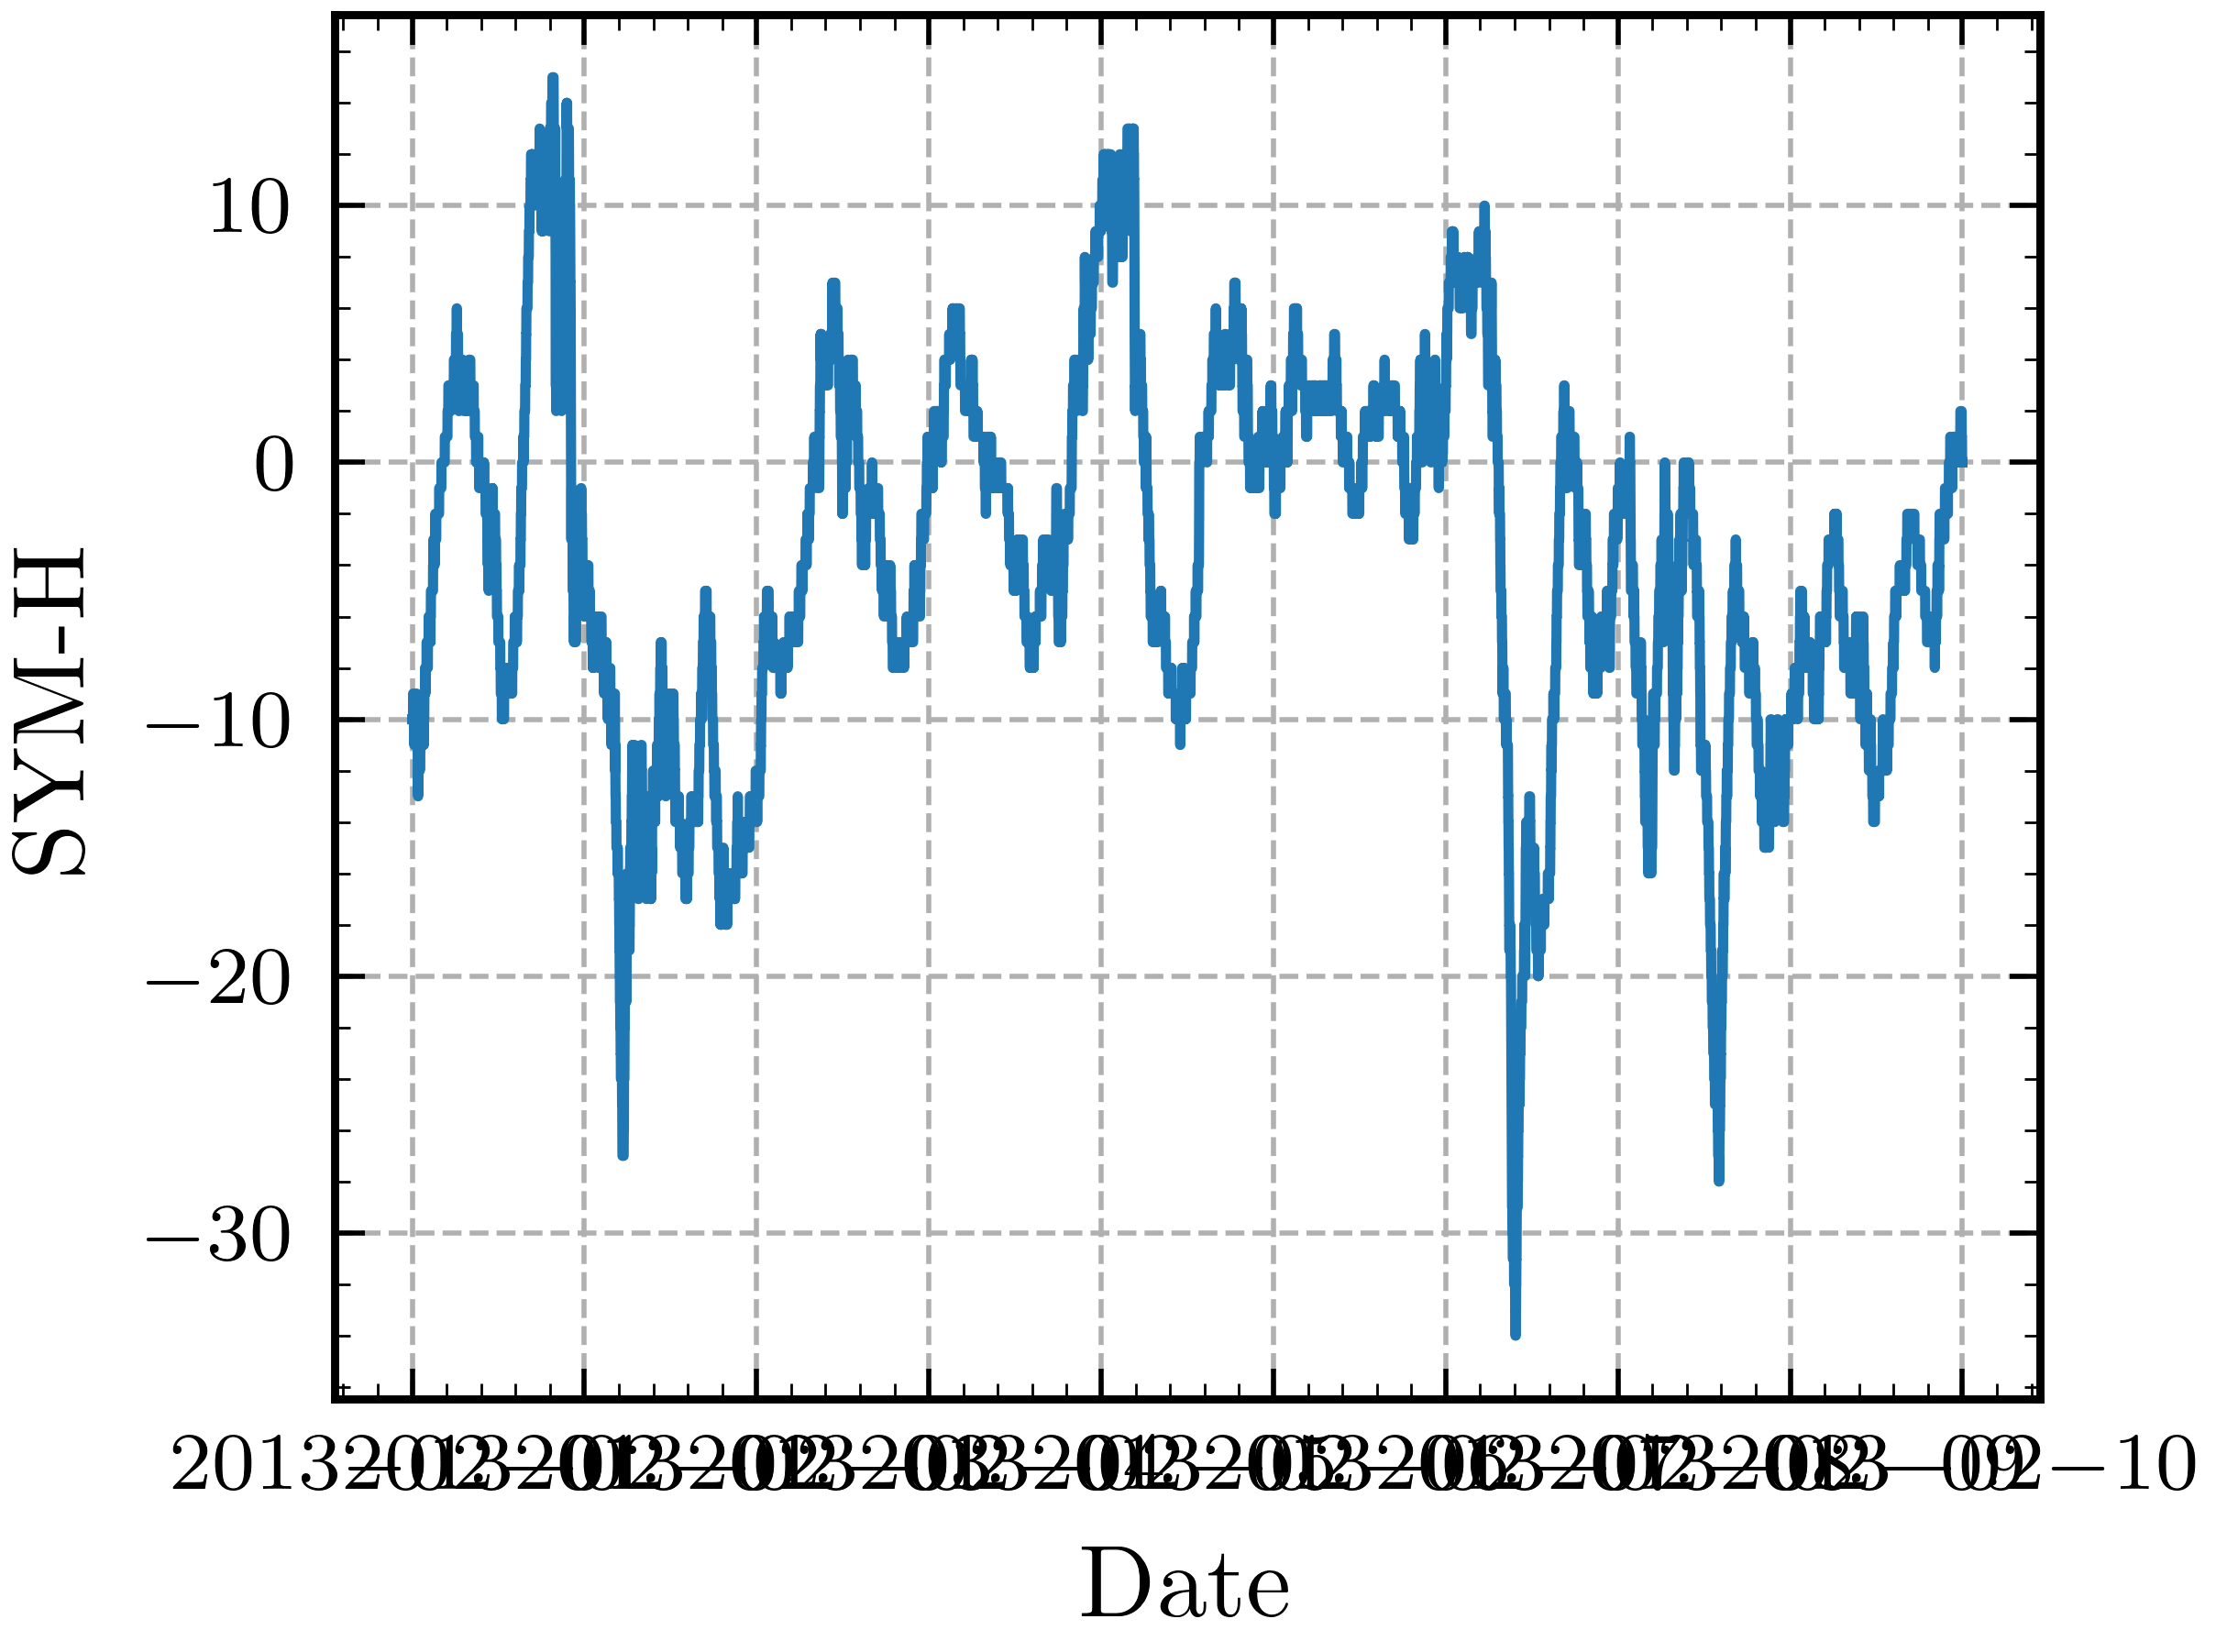

In [ ]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel('Date')
ax.set_ylabel('SYM-H')
# ax.set_xlim(0, N_EPOCHS['radar'])
# ax.set_ylim(0, 5)

ax.plot(df_reduced['Timestamp'], df_reduced['SYM-H'],
        color='tab:blue', ls='-', lw=1)

# ax.legend(loc='upper right', framealpha=0)
# fig.savefig('../images/tp2_fig1.pdf')
plt.show()

In [ ]:
data_train, data_test = train_test_split(df_reduced['SYM-H'],
                                         test_size=TEST_SIZE,
                                         shuffle=False)

In [ ]:
print(data_train.shape, data_test.shape)

(10368,) (2593,)


In [ ]:
scaler = MinMaxScaler()
data_train = data_train.to_numpy().reshape(-1, 1)
data_train_scaled = scaler.fit_transform(data_train)

In [ ]:
print(data_train_scaled)

[[0.48979592]
 [0.48979592]
 [0.48979592]
 ...
 [0.3877551 ]
 [0.3877551 ]
 [0.40816327]]


In [ ]:
data_test = data_test.to_numpy().reshape(-1, 1)
# Use the scaler trained with the train data
data_test_scaled = scaler.transform(data_test)
print(data_test_scaled)

[[0.42857143]
 [0.44897959]
 [0.46938776]
 ...
 [0.69387755]
 [0.69387755]
 [0.69387755]]


In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    x, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [ ]:
# Define sliding window
x, y = split_sequence(data_train_scaled,
                      n_steps_in=N_STEPS_IN,
                      n_steps_out=N_STEPS_OUT)

## Modeling

In [ ]:
model = Sequential()
model.add(Dense(units=N_NEURONS,
                activation=ACTIVATION_FUNCTION,
                input_dim=N_STEPS_IN))
model.add(Dense(units=N_STEPS_OUT))
model.compile(optimizer=OPTIMIZER,
              loss=LOSS_FUNCTION)
history = model.fit(x, y, epochs=N_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=VERBOSE_TYPE)

2022-08-11 15:56:46.286199: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-11 15:56:46.286229: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-11 15:56:46.286250: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neuromancer): /proc/driver/nvidia/version does not exist
2022-08-11 15:56:46.286601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


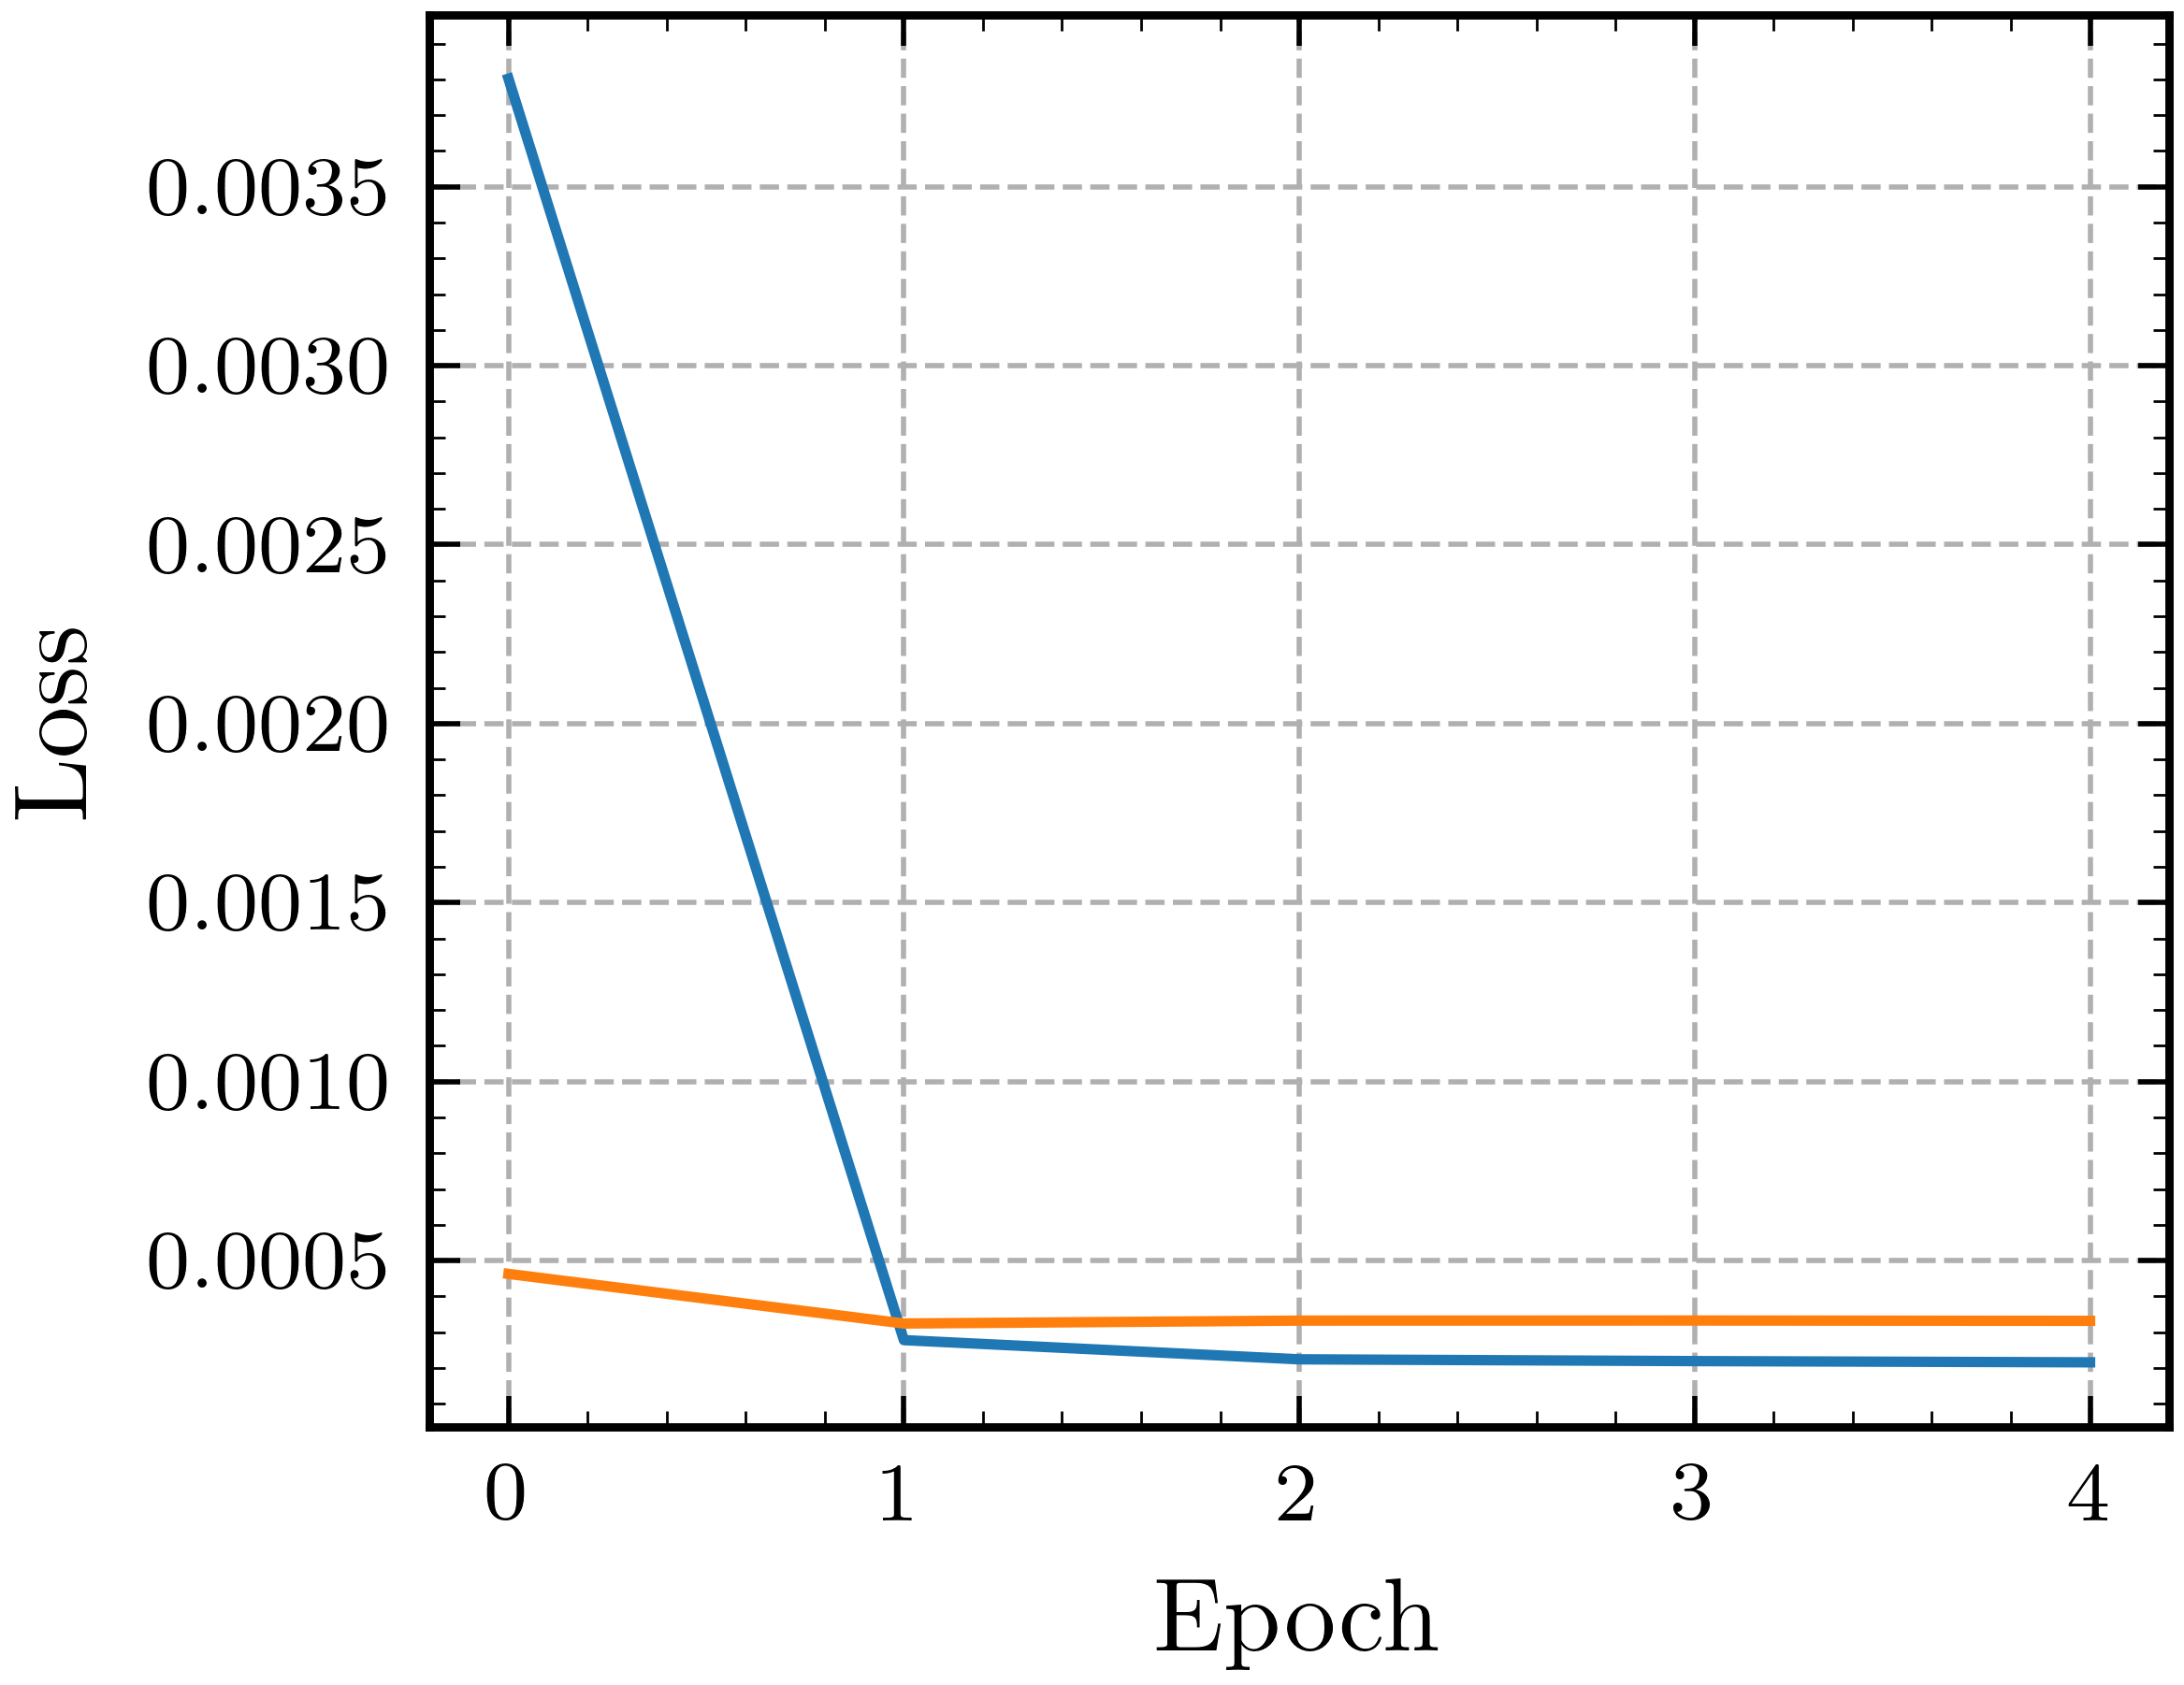

In [ ]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
# ax.set_xlim(0, N_EPOCHS['radar'])
# ax.set_ylim(0, 5)

ax.plot(history.history['loss'], color='tab:blue',
        ls='-', lw=1)
ax.plot(history.history['val_loss'], color='tab:orange',
        ls='-', lw=1)

# ax.legend(loc='upper right', framealpha=0)
# fig.savefig('../images/tp2_fig3.pdf')
plt.show()

## Prediction and Validation

In [24]:
y_hat_1 = model.predict(data_train_scaled[-N_STEPS_IN:].reshape(1, -1))

1/1 [==============================] - 0s 64ms/step


In [33]:
mse = mean_squared_error(y_hat_1, data_test_scaled[0:3].reshape(1, -1))
print(mse)

0.00398325168965305


In [35]:
y_pred = scaler.inverse_transform(y_hat_1)
print(y_pred)

[[-15.166226 -15.21681  -14.69472 ]]
